In [1]:
import pandas as pd
import numpy as np
from pyarrow.feather import read_feather
from pathlib import Path
from ephys_queries import select_ifr, db_setup_core, select_spike_times, select_neurons
from dotenv import load_dotenv

In [2]:
from spiketimes.df import mean_firing_rate_ifr_by_neuron, cv_isi_by_neuron
from spiketimes.df import spikes_df_to_binned_df, df_binned_to_bool, fraction_silent_by_neuron
from spiketimes.df import waveform_width_by_neuron, peak_asymmetry_by_neuron
from spiketimes.df import correlate_all_neurons, correlate_all_neurons_by

In [3]:
data_dir = Path(".").absolute().parent / "data" 
df_peaks = read_feather(data_dir / "waveform_peaks.feather")
df_waves = read_feather(data_dir / "waveforms.feather")

In [4]:
load_dotenv()
engine, metadata = db_setup_core()

df_ifr = select_ifr(engine, metadata, exp_names=["OPTO"], block_name="pre")
df_spikes = select_spike_times(engine, metadata, exp_names=["OPTO"], block_name="pre")
df_neurons = select_neurons(engine, metadata, exp_names=["OPTO"])

In [5]:
df_mfr = mean_firing_rate_ifr_by_neuron(df_ifr)
df_cv = (
    df_spikes
    .assign(spikes=df_spikes["spike_time_samples"].divide(30000))
    .pipe(lambda x: cv_isi_by_neuron(x, spiketimes_col="spikes"))
)

/home/rory/repos/opto_analysis/venv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rory/repos/opto_analysis/venv/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rory/repos/opto_analysis/venv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rory/repos/opto_analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1040: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
/home/rory/repos/opto_analysis/venv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
df_bin = (
    df_spikes
    .assign(spiketimes=df_spikes.spike_time_samples.divide(30000))
    .pipe(lambda x: spikes_df_to_binned_df(x, spiketimes_col="spiketimes", fs=1, t_start=0))
)
df_sil = (
    df_bin
    .assign(has_spike=df_binned_to_bool(df_bin["spike_count"]))
    .pipe(lambda x: fraction_silent_by_neuron(x, bool_col="has_spike"))
)

In [7]:
df_waveform_width = waveform_width_by_neuron(df_peaks.dropna())
df_asym = peak_asymmetry_by_neuron(df_peaks)

In [9]:
df_corr = (
            pd.merge(df_bin, df_neurons[["id", "session_name"]], left_on="neuron_id", right_on="id")
            .pipe(lambda x: correlate_all_neurons_by(x, binned_spikes_col="spike_count", by_col="session_name"))
)


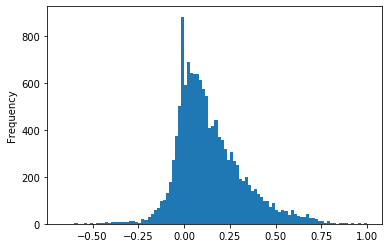

In [11]:
df_corr.pearson_r.plot(kind="hist", bins=100)